Number of training images in each class:
angry: 3995 images
disgusted: 436 images
fearful: 4097 images
happy: 7215 images
sad: 4830 images
surprised: 3171 images
neutral: 4965 images

Number of test images in each class:
angry: 958 images
disgusted: 111 images
fearful: 1024 images
happy: 1774 images
sad: 1247 images
surprised: 831 images
neutral: 1233 images

Image size: (48, 48, 3)
Model created
Model loaded from emotion_recognition_model.pth
Model training started
Epoch 1/20, Loss: 1.5276672455144087
Epoch 2/20, Loss: 1.5020347026514849
Epoch 3/20, Loss: 1.4804928029300375
Epoch 4/20, Loss: 1.4615759058359736
Epoch 5/20, Loss: 1.4403291768114392
Epoch 6/20, Loss: 1.42177263081472
Epoch 7/20, Loss: 1.4077994313696711
Epoch 8/20, Loss: 1.3990426937031055
Epoch 9/20, Loss: 1.3838997471306
Epoch 10/20, Loss: 1.3696585490071693
Epoch 11/20, Loss: 1.3609637908786867
Epoch 12/20, Loss: 1.35466296688751
Epoch 13/20, Loss: 1.3427824713870518
Epoch 14/20, Loss: 1.3377575391119467
Epoch 15/20, 

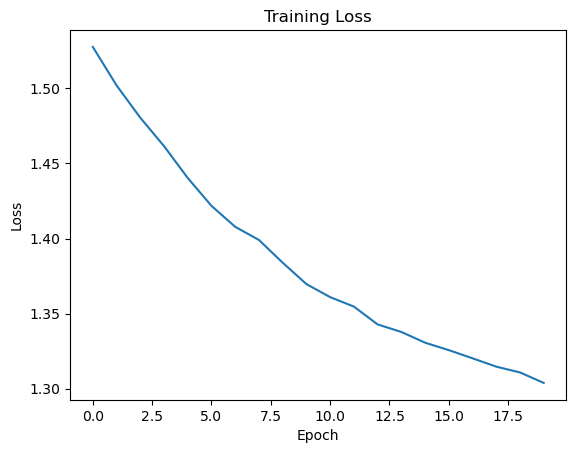

Finished Training
Model saved as emotion_recognition_model.pth
Predicted emotion: angry


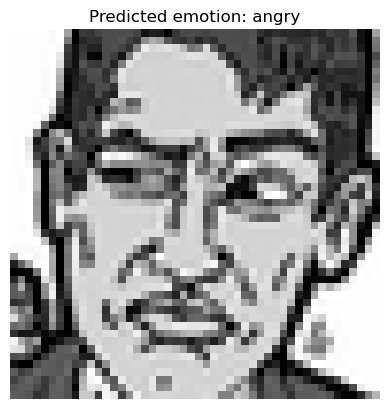

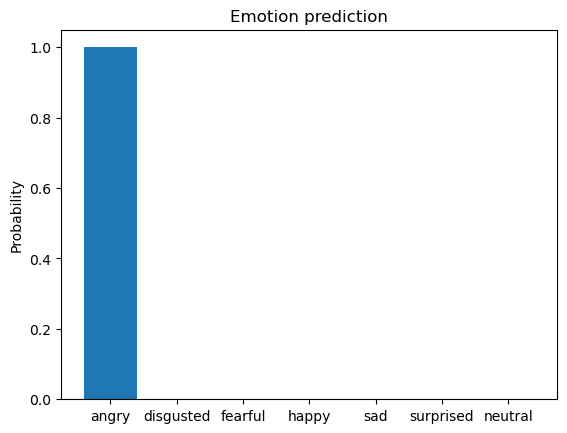

Loss: 1.566012506991361, Accuracy: 0.5927835051546392


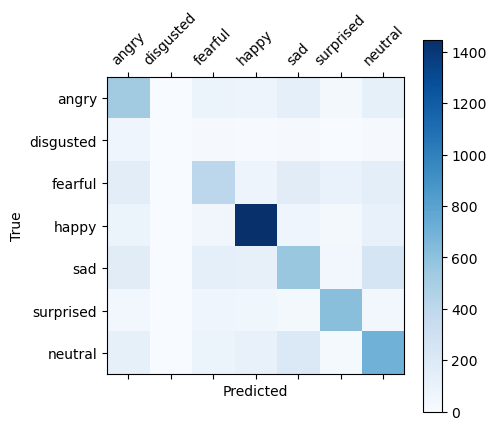

In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

# Directories
train_dir = 'dataset/train'
test_dir = 'dataset/test'
cache_dir = 'cache'
model_dir = 'models'

# List of classes
classes = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

# Number of images in each class
print('Number of training images in each class:')
for c in classes:
    path = os.path.join(train_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
print('\nNumber of test images in each class:')
for c in classes:
    path = os.path.join(test_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
# Image size
img = cv2.imread('dataset/train/angry/im0.png')
print(f'\nImage size: {img.shape}')

# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.file_paths = []
        self.labels = []

        for idx, class_name in enumerate(classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.file_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = EmotionDataset(train_dir, classes, transform)
test_dataset = EmotionDataset(test_dir, classes, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.01)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu4(self.bn4(self.fc1(x))))
        x = self.softmax(self.fc2(x))
        return x

model = EmotionCNN(num_classes=len(classes))
print("Model created")

# If model file exists, load the model
if os.path.exists('emotion_recognition_model.pth'):
    model.load_state_dict(torch.load('emotion_recognition_model.pth'))
    print('Model loaded from emotion_recognition_model.pth')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print('Model training started')

# Training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
        loss_history.append(running_loss/len(train_loader))
        
    # Plot loss history
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    print('Finished Training')

train_model(model, train_loader, criterion, optimizer, 20)

# Save the model
torch.save(model.state_dict(), 'emotion_recognition_model.pth')
print('Model saved as emotion_recognition_model.pth')

# Load the model for testing
model.load_state_dict(torch.load('emotion_recognition_model.pth'))
model.eval()

# Test the model on a single image
def predict_emotion(model, img_path, classes, transform):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        emotion = classes[predicted.item()]
        return emotion, output

img_path = 'dataset/test/angry/im0.png'
emotion, output = predict_emotion(model, img_path, classes, transform)
print(f'Predicted emotion: {emotion}')

# Display image
image = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Predicted emotion: {emotion}')
plt.savefig('test_image.png')
plt.show()

# Display prediction
plt.bar(classes, output[0].numpy())
plt.ylabel('Probability')
plt.title('Emotion prediction')
plt.savefig('prediction.png')
plt.show()

# Show loss and accuracy
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Loss: {running_loss/len(test_loader)}, Accuracy: {correct/total}')
    
test_model(model, test_loader, criterion)

# Display confusion matrix
def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    confusion_matrix = np.zeros((len(classes), len(classes)))
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                confusion_matrix[labels[i]][predicted[i]] += 1
    
    plt.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
plot_confusion_matrix(model, test_loader, classes)